# __Прогнозирование уровня средней заработной платы в России__

__Придерживайтесь стандартного алгоритма построения прогноза:__

1. Визуальный анализ ряда  
2. Стабилизация дисперсии (при необходимости)  
3. Выбор порядка дифференцирования  
4. Выбор начальных приближений для p, q, P, Qp,q,P,Q  
5. Обучение и сравнение моделей-кандидатов, выбор победителя  
6. Анализ остатков построенной модели, при необходимости — её модификация: если остатки получаются смещёнными, прогноз нужно скорректировать на константу; если остатки нестационарны или автокоррелированы, можно попробовать расширить область, в которой подбираются значения p, q, P, Qp,q,P,Q.  
7. Прогнозирование с помощью финальной модели.  

Загрузка необходимых модулей

In [24]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product
from statsmodels.tsa.arima_model import ARIMA

Populating the interactive namespace from numpy and matplotlib


Обратное преобразование Бокса-Кокса для стабилизации дисперсии

In [2]:
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

Считывание данных в формате csv

In [3]:
pd.read_csv?

In [4]:
wag = pd.read_csv('WAG_C_M.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True)

In [5]:
wag

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5
...,...
2016-04-01,36497.0
2016-05-01,37270.0
2016-06-01,38447.0


wag.index

## __1. Визуальный анализ ряда__

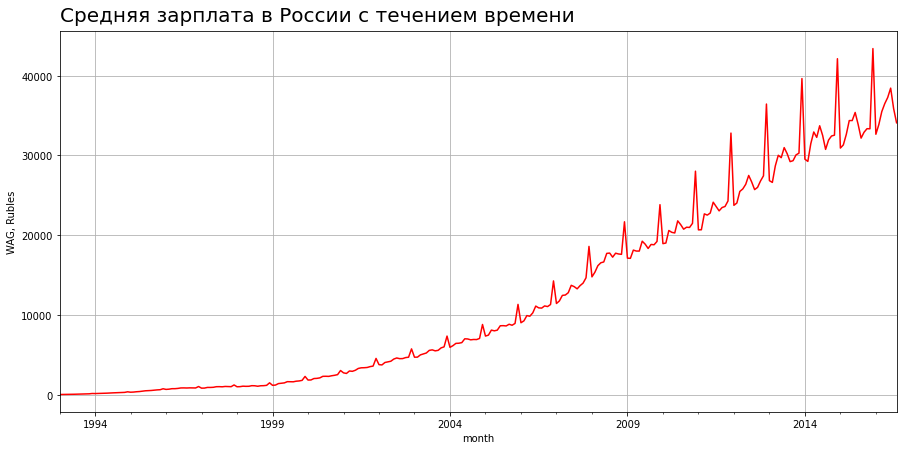

In [6]:
plt.figure(figsize(15,7))

wag.WAG_C_M.plot(color='red')

plt.title("Средняя зарплата в России с течением времени", fontdict={"fontsize" : 20}, loc='left', pad=10)
plt.ylabel('WAG, Rubles')
plt.grid()
plt.show()

In [7]:
# sm.tsa.stattools.adfuller - имплементация критерия Дики-Фуллера

In [8]:
sm.tsa.seasonal_decompose(wag.WAG_C_M).plot

<bound method DecomposeResult.plot of <statsmodels.tsa.seasonal.DecomposeResult object at 0x7fe17dab00a0>>

Критерий Дики-Фуллера: p=0.991850


<Figure size 1080x720 with 0 Axes>

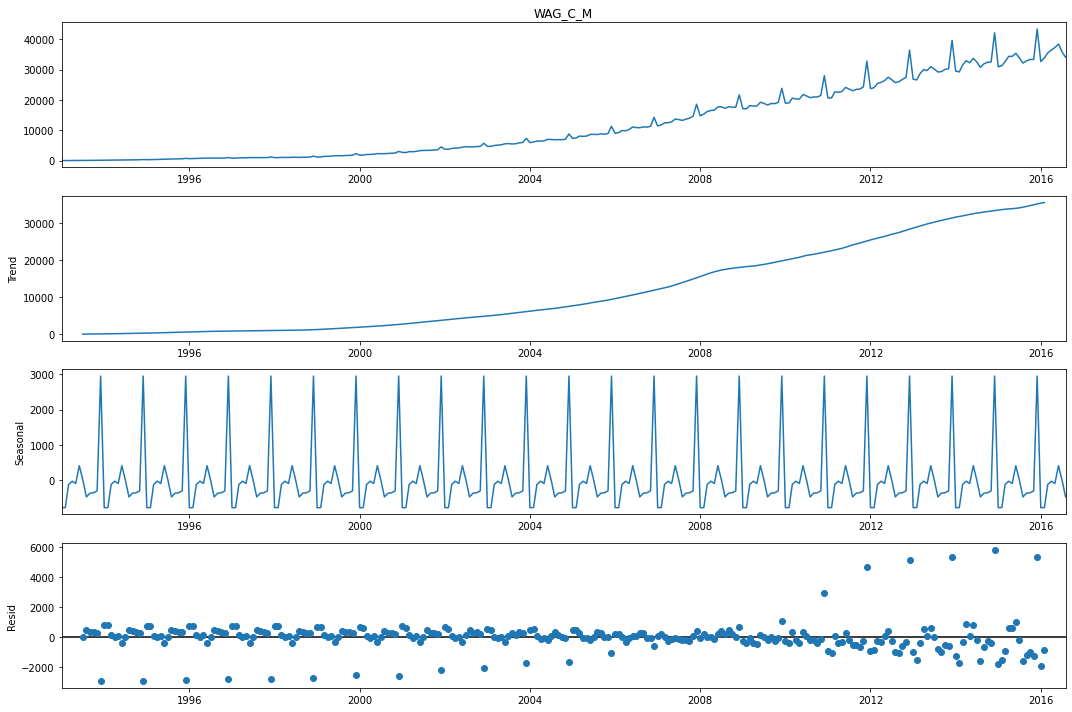

In [9]:
plt.figure(figsize(15,10))

sm.tsa.seasonal_decompose(wag.WAG_C_M).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wag.WAG_C_M)[1])

## __Основные выводы по визуальному анализу:__
1. Налицо восходящий тренд средних зарплат
2. Присутствует сезонность в данных
3. Дисперсия нестабильная
4. Критерий Дики-Фуллера гипеотезу о не стационарности ряда уверенно не отвергает

## __2. Стабилизация дисперсии__
### 2.1 Применим стабилизацию Бокса-Кокса

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p = 0.696899


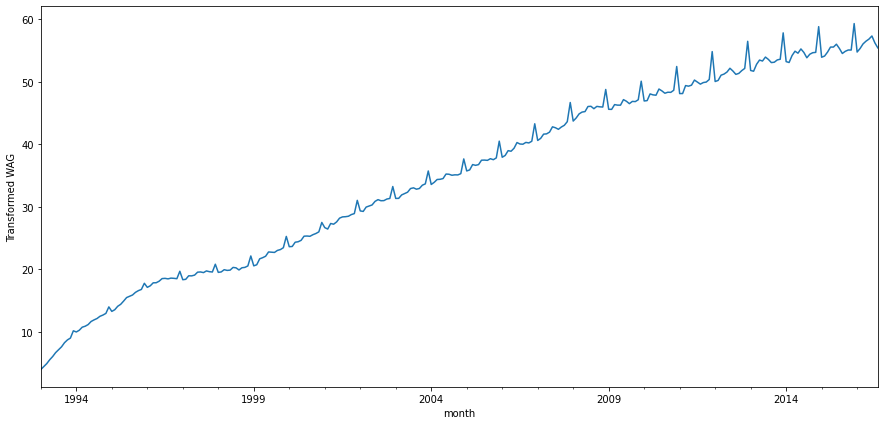

In [10]:
plt.figure(figsize(15,7))

wag['WAG_box'], lmbda = stats.boxcox(wag.WAG_C_M)
wag.WAG_box.plot()

plt.ylabel(u'Transformed WAG')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p = %f" % sm.tsa.stattools.adfuller(wag.WAG_box)[1])

Критерий Дики-Фуллера уверенно не отвергает гипотезу о нестационарности.  
Визуально данное утверждение __подтверждается__

## __3. Выбор порядка дифференцирования__
### 3.1 Сезонное дифференцирование - лаг  12 месяцев
Сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

In [11]:
plt.figure(figsize(15,10))
wag['WAG_box_season_diff'] = wag.WAG_box - wag.WAG_box.shift(12)

<Figure size 1080x720 with 0 Axes>

In [12]:
wag.head(15)

,WAG_C_M,WAG_box,WAG_box_season_diff
month,,,
1993-01-01,15.3,3.990393,NaN
1993-02-01,19.1,4.458758,NaN
1993-03-01,23.6,4.931635,NaN
1993-04-01,30.6,5.549430,NaN
1993-05-01,37.5,6.063406,NaN
1993-06-01,47.4,6.690719,NaN
1993-07-01,56.0,7.161310,NaN
1993-08-01,65.4,7.618224,NaN
1993-09-01,80.9,8.275619,NaN


Критерий Дики-Фуллера: p=0.014697


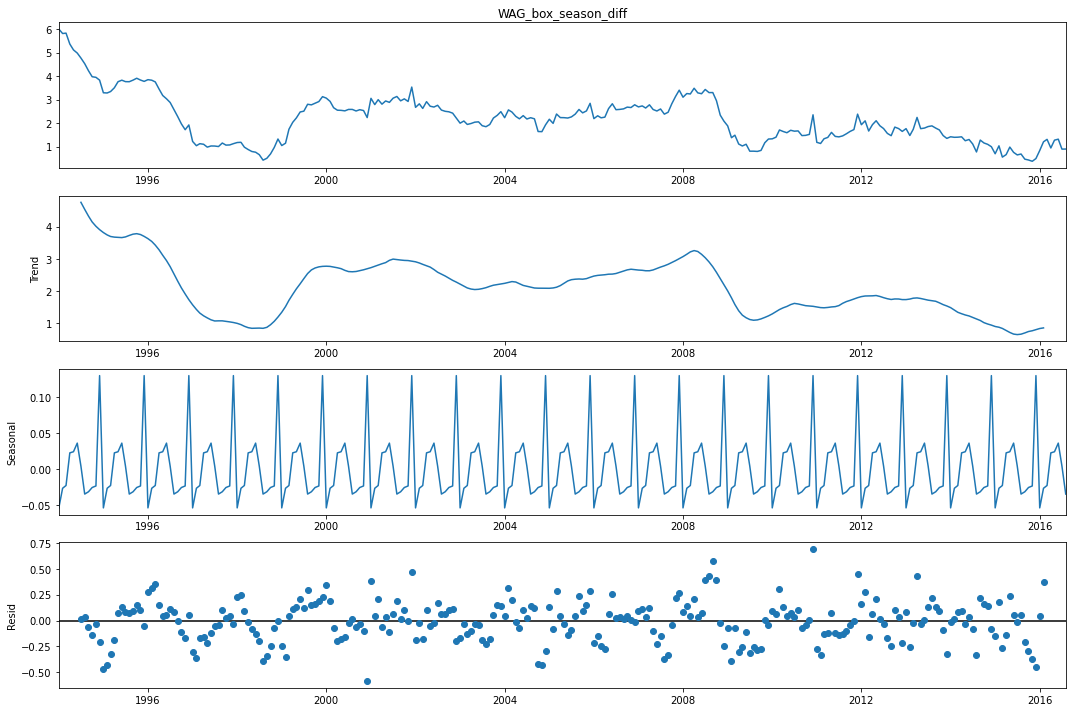

In [13]:
# учтем смещение отсутствующих данных после дифференцирования
sm.tsa.seasonal_decompose(wag.WAG_box_season_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wag.WAG_box_season_diff[12:])[1])

Сезонное дифференцирвоание не позволило полностью избавиться от тренда в данных. Однако преобразования Бокса-Кокса частично решили проблему гетероскедастичности, что продемонстрировано на графике с остатакми.

### 3.2 Применим __обычное__ дифференцирование

In [14]:
plt.figure(figsize(15,10))
wag['WAG_box_season_ordinary_diff'] = wag.WAG_box_season_diff - wag.WAG_box_season_diff.shift(1)

<Figure size 1080x720 with 0 Axes>

In [15]:
wag.head(15)

,WAG_C_M,WAG_box,WAG_box_season_diff,WAG_box_season_ordinary_diff
month,,,,
1993-01-01,15.3,3.990393,NaN,NaN
1993-02-01,19.1,4.458758,NaN,NaN
1993-03-01,23.6,4.931635,NaN,NaN
1993-04-01,30.6,5.549430,NaN,NaN
1993-05-01,37.5,6.063406,NaN,NaN
1993-06-01,47.4,6.690719,NaN,NaN
1993-07-01,56.0,7.161310,NaN,NaN
1993-08-01,65.4,7.618224,NaN,NaN
1993-09-01,80.9,8.275619,NaN,NaN


Критерий Дики-Фуллера: p=0.000000


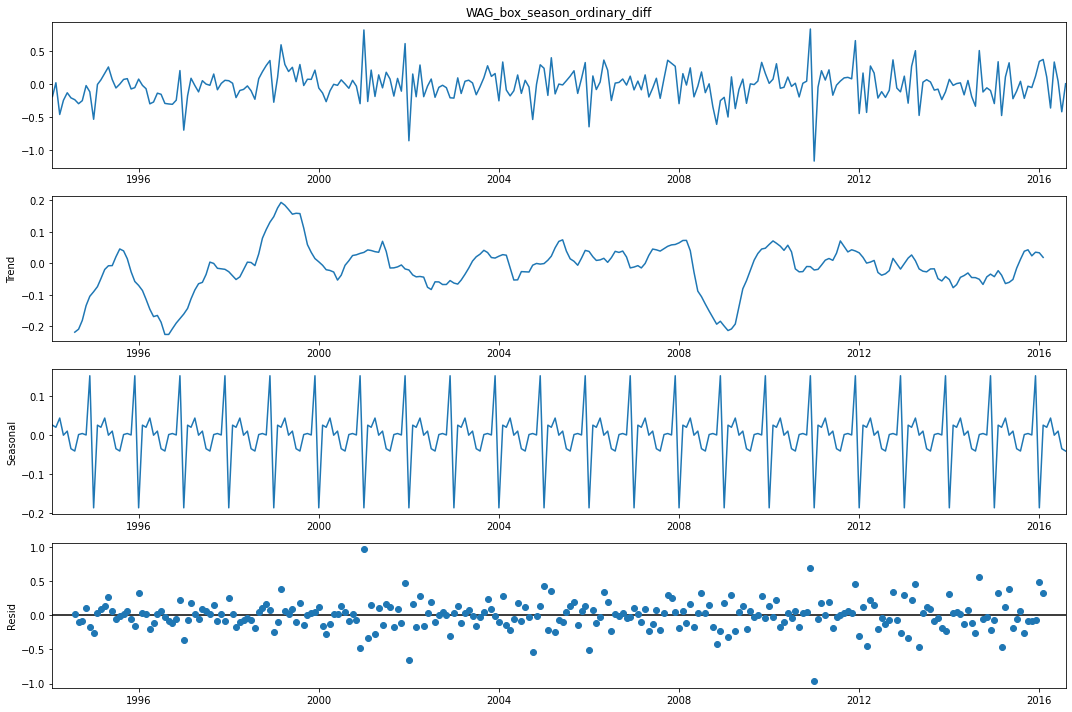

In [16]:
sm.tsa.seasonal_decompose(wag.WAG_box_season_ordinary_diff[13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wag.WAG_box_season_ordinary_diff[13:])[1])

## __Основные выводы по стабилизации дисперсии:__
Наложение преобразования Бокса-Кокса, а также сезонное и последующее простое дифференцирование позволили полностью избавиться от гетероскедастичности и нестационарности в данных, что подтверждается графиками тренда и распределение остатков. 

Также критерий Дики-Фуллера __уверенно отвергает гипотезу о нестационарности__

## 4. Выбор начальных приближений для p, q, P, Q
Посмотрим на ACF и PACF полученного ряда:

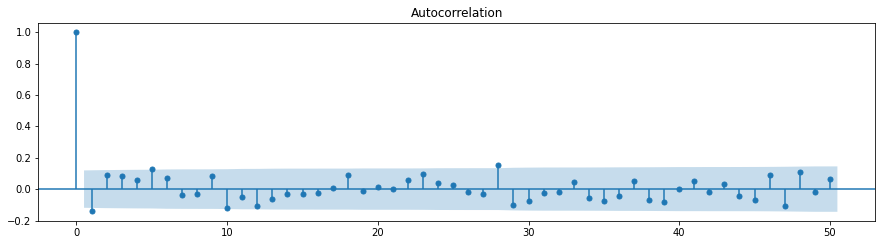

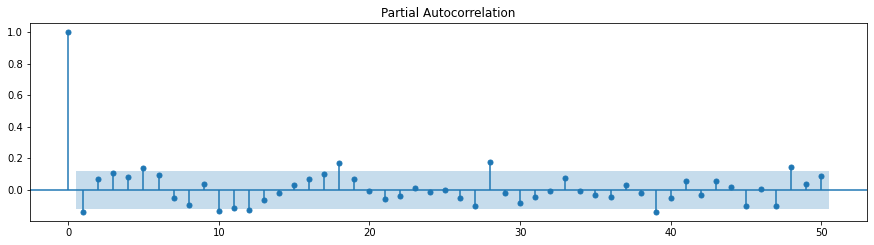

In [17]:
plt.figure(figsize(15,8))
# одновременно строим поле для двух графиков
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(wag.WAG_box_season_ordinary_diff[13:].values.squeeze(), lags=50, ax=ax)
plt.show()

ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(wag.WAG_box_season_ordinary_diff[13:].values.squeeze(), lags=50, ax=ax)
plt.show()

Начальные приближения: Q=0, q=5, P=4, p=5
Тип модели - SARIMA (p, d, q) * (P,D ,Q)  

S = 12 месяцев  
d = 1 простое дифференцирование  
D = 1 сезонное дифференцирование  

In [18]:
ps = range(0, 6)
d  = 1
qs = range(0, 6)

Ps = range(0, 5)
D  = 1
Qs = range(0, 1)

In [19]:
# общее количество параметров в модели
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

180

In [21]:
parameters_list

[(0, 0, 0, 0),
 (0, 0, 1, 0),
 (0, 0, 2, 0),
 (0, 0, 3, 0),
 (0, 0, 4, 0),
 (0, 1, 0, 0),
 (0, 1, 1, 0),
 (0, 1, 2, 0),
 (0, 1, 3, 0),
 (0, 1, 4, 0),
 (0, 2, 0, 0),
 (0, 2, 1, 0),
 (0, 2, 2, 0),
 (0, 2, 3, 0),
 (0, 2, 4, 0),
 (0, 3, 0, 0),
 (0, 3, 1, 0),
 (0, 3, 2, 0),
 (0, 3, 3, 0),
 (0, 3, 4, 0),
 (0, 4, 0, 0),
 (0, 4, 1, 0),
 (0, 4, 2, 0),
 (0, 4, 3, 0),
 (0, 4, 4, 0),
 (0, 5, 0, 0),
 (0, 5, 1, 0),
 (0, 5, 2, 0),
 (0, 5, 3, 0),
 (0, 5, 4, 0),
 (1, 0, 0, 0),
 (1, 0, 1, 0),
 (1, 0, 2, 0),
 (1, 0, 3, 0),
 (1, 0, 4, 0),
 (1, 1, 0, 0),
 (1, 1, 1, 0),
 (1, 1, 2, 0),
 (1, 1, 3, 0),
 (1, 1, 4, 0),
 (1, 2, 0, 0),
 (1, 2, 1, 0),
 (1, 2, 2, 0),
 (1, 2, 3, 0),
 (1, 2, 4, 0),
 (1, 3, 0, 0),
 (1, 3, 1, 0),
 (1, 3, 2, 0),
 (1, 3, 3, 0),
 (1, 3, 4, 0),
 (1, 4, 0, 0),
 (1, 4, 1, 0),
 (1, 4, 2, 0),
 (1, 4, 3, 0),
 (1, 4, 4, 0),
 (1, 5, 0, 0),
 (1, 5, 1, 0),
 (1, 5, 2, 0),
 (1, 5, 3, 0),
 (1, 5, 4, 0),
 (2, 0, 0, 0),
 (2, 0, 1, 0),
 (2, 0, 2, 0),
 (2, 0, 3, 0),
 (2, 0, 4, 0),
 (2, 1, 0, 0),
 (2, 1, 1,

### __5. Обучение и сравнение моделей-кандидатов, выбор победителя__

In [20]:
wag.WAG_box

month
1993-01-01     3.990393
1993-02-01     4.458758
1993-03-01     4.931635
1993-04-01     5.549430
1993-05-01     6.063406
                ...    
2016-04-01    56.526742
2016-05-01    56.860441
2016-06-01    57.358885
2016-07-01    56.260153
2016-08-01    55.455409
Name: WAG_box, Length: 284, dtype: float64

In [27]:
ARIMA(wag.WAG_box, order=(parameters_list[0][0], d, parameters_list[0][0]))

/home/tater/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/tater/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [ ]:
        model=sm.tsa.statespace.SARIMAX(wag.WAG_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)

In [25]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model= ARIMA(wag.WAG_box, order=(param[0][0], d, parameters_list[0][0]))
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

CPU times: user 1h 26min 37s, sys: 1h 17min 53s, total: 2h 44min 30s
Wall time: 20min 46s


In [26]:
# Выбор оптимальной модели по критерию информативности Акаике
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

       parameters        aic
176  (5, 5, 1, 0) -25.164730
146  (4, 5, 1, 0) -23.825222
177  (5, 5, 2, 0) -23.506345
147  (4, 5, 2, 0) -22.652391
175  (5, 5, 0, 0) -22.200048


/home/tater/ML_coursera/ML/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [27]:
# Тогда параметры лучшей модели
print(best_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                             WAG_box   No. Observations:                  284
Model:             SARIMAX(5, 1, 5)x(1, 1, [], 12)   Log Likelihood                  24.582
Date:                             Mon, 14 Jun 2021   AIC                            -25.165
Time:                                     17:49:01   BIC                             18.061
Sample:                                 01-01-1993   HQIC                            -7.809
                                      - 08-01-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2216      2.296     -0.097      0.923      -4.723       4.279
ar.L2          0.2422      

/home/tater/ML_coursera/ML/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## __6. Анализ остатков построенной модели__

/home/tater/ML_coursera/ML/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Критерий Стьюдента: p=0.165023
Критерий Дики-Фуллера: p=0.000000


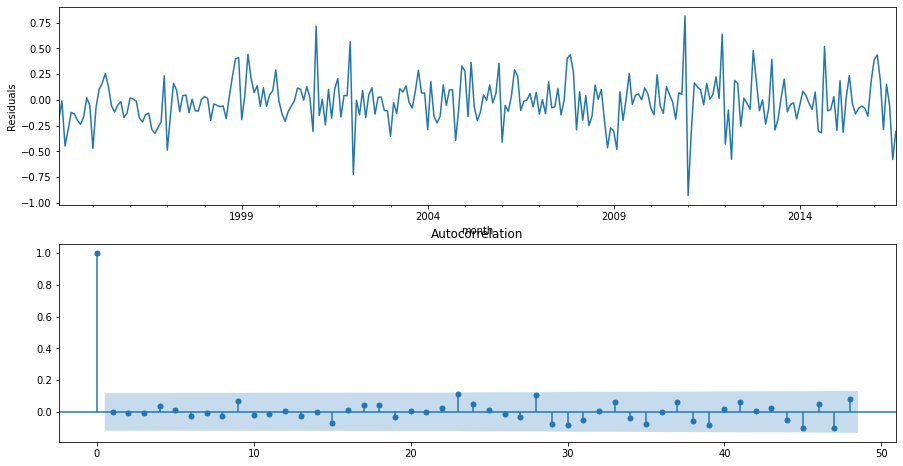

In [28]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).Дальнейших действий совершать __не требуется__
Посмотрим, насколько хорошо модель описывает данные:

/home/tater/ML_coursera/ML/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


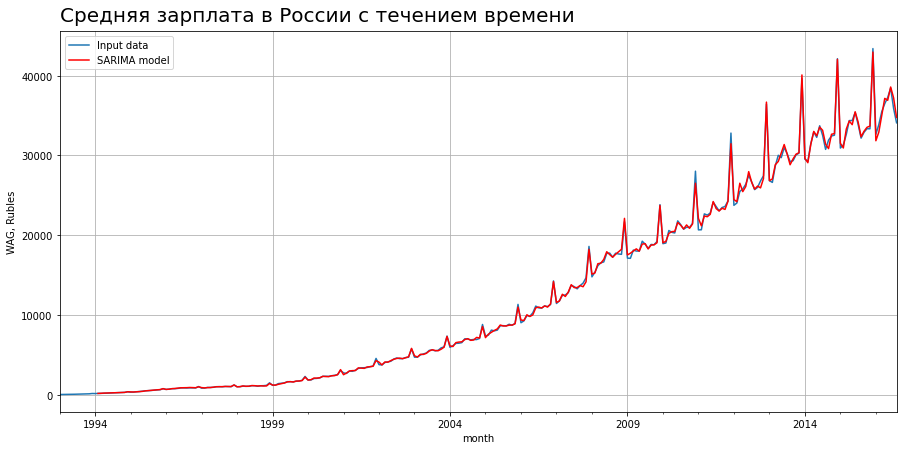

In [29]:
plt.figure(figsize(15,7))
wag['model'] = invboxcox(best_model.fittedvalues, lmbda)

wag.WAG_C_M.plot(label="Input data")
wag.model[13:].plot(color='r', label="SARIMA model")

plt.ylabel('WAG, Rubles')
plt.grid()
plt.title("Средняя зарплата в России с течением времени", fontdict={"fontsize" : 20}, loc='left', pad=10)
plt.legend()
plt.show()

## __Основные выводы по визуальному анализу:__
1. Модель визуально с высокой точностью описывает исходные данные
2. Модель будем считать адекватной для построения последующего прогноза

## __7. Прогнозирование с помощью финальной модели__

/home/tater/ML_coursera/ML/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


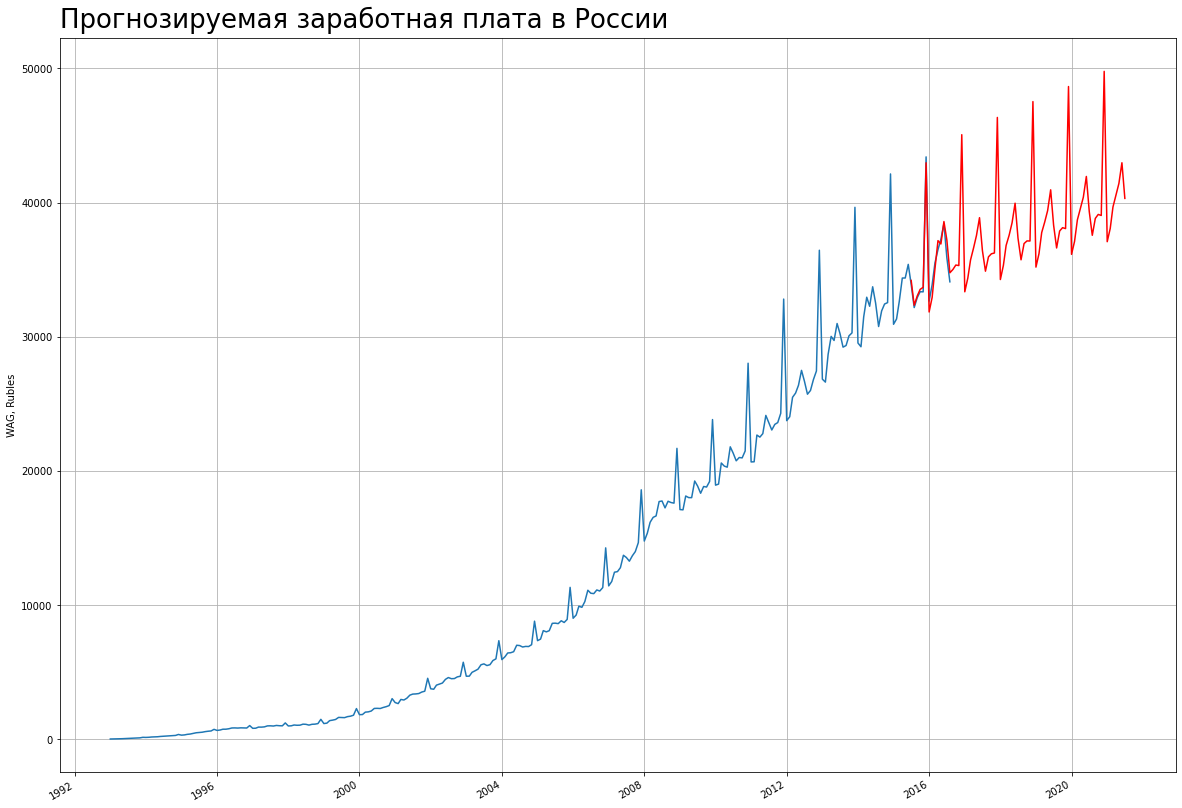

In [31]:
wag2 = wag[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-08-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,60)]

future = pd.DataFrame(index=date_list, columns= wag2.columns)
wag2 = pd.concat([wag2, future])
wag2['forecast'] = invboxcox(best_model.predict(start=270, end=500), lmbda)

plt.figure(figsize(20,15))
wag2.WAG_C_M.plot(label="Input data")
wag2.forecast.plot(color='r', label='SARIMA model forecast')

plt.title("Прогнозируемая заработная плата в России", fontdict={"fontsize" : 26}, loc='left', pad=10)
plt.ylabel('WAG, Rubles')
plt.grid()
plt.show()

## __8. Проверка модели с акутальными данными__

Выполним проверку смоделированного прогноза на 5 лет. Для этого скачаем актуальные данные с сайта Росстат о величине средних заработных плат за 2021 год.

In [32]:
wag_actual = pd.read_csv('WAG_Russia_2021.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True)

/home/tater/ML_coursera/ML/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


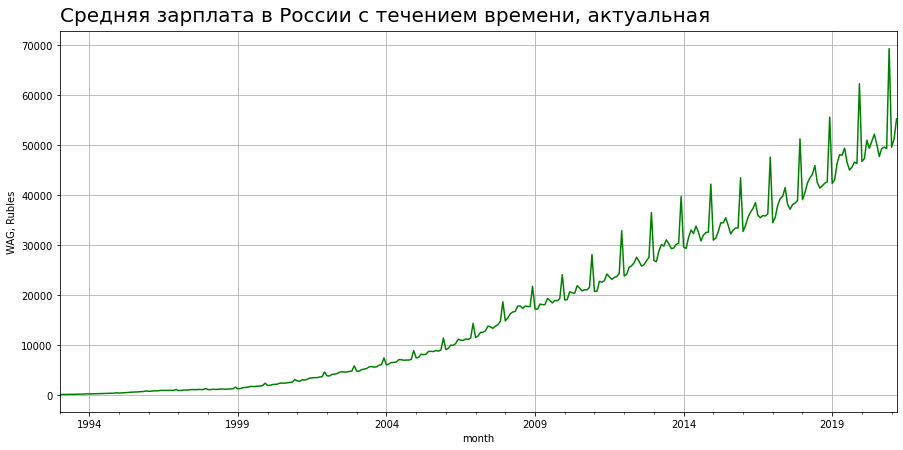

In [33]:
plt.figure(figsize(15,7))

wag_actual.WAG_C_M.plot(color='green')

plt.title("Средняя зарплата в России с течением времени, актуальная", fontdict={"fontsize" : 20}, loc='left', pad=10)
plt.ylabel('WAG, Rubles')
plt.grid()
plt.show()

/home/tater/ML_coursera/ML/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


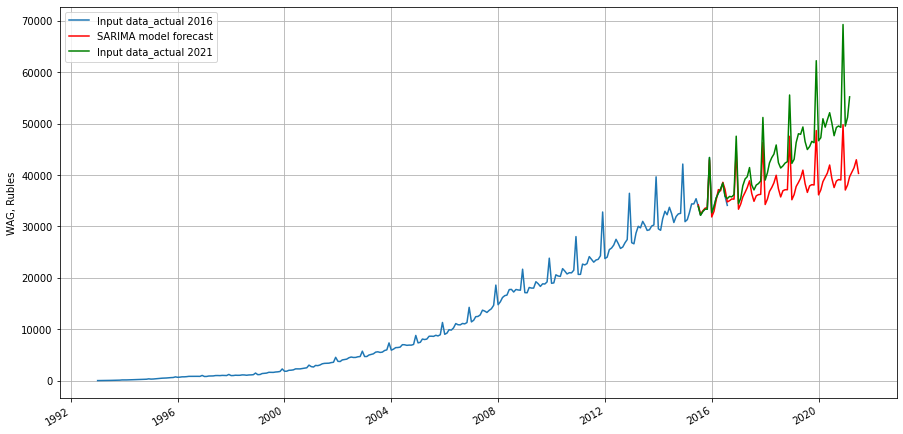

In [34]:
wag2 = wag[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-08-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,60)]

future = pd.DataFrame(index=date_list, columns= wag2.columns)
wag2 = pd.concat([wag2, future])

wag2['forecast'] = invboxcox(best_model.predict(start=270, end=344), lmbda)
wag2['actual'] = wag_actual.WAG_C_M[270:344]

plt.figure(figsize(15,8))
wag2.WAG_C_M.plot(label="Input data_actual 2016")
wag2.forecast.plot(color='r', label='SARIMA model forecast')
wag2.actual.plot(color='g', label='Input data_actual 2021')

plt.grid()
plt.legend()
plt.ylabel('WAG, Rubles')
pylab.show()

In [35]:
wag2

/home/tater/ML_coursera/ML/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,WAG_C_M,forecast,actual
1993-01-01,15.3,NaN,NaN
1993-02-01,19.1,NaN,NaN
1993-03-01,23.6,NaN,NaN
1993-04-01,30.6,NaN,NaN
1993-05-01,37.5,NaN,NaN
...,...,...,...
2021-03-01,NaN,39670.944049,55208.0
2021-04-01,NaN,40566.054104,NaN
2021-05-01,NaN,41427.049180,NaN
2021-06-01,NaN,42970.516608,NaN


## __Основные выводы по сравнению:__
Хоть и подобранная модель на данные по среднемесячной зарплате россиян до 2016 года показала свою адекватность, она имеет довольно большую погрешность с реальным положением дел на момент марта 2021 года.  Модель фактически занижает показания действительности.